# Text Generation with Transformers

In this notebook we use the components developed in `modelling.transformer` to train a transformer decoder for our text generation task. We will compare the performance of this model with that established by our RNN baseline.

## Imports

The bulk of the code required to setup, train and generate new text from the model, is contained within `modelling.transformer` (check the source code for the details). We import this module together with others that serve the training data and manage model persistence.

In [1]:
import warnings

from torch import device
from torch.utils.data import DataLoader

from modelling import data as data
from modelling import transformer as tfr
from modelling import utils as utils

warnings.filterwarnings("ignore")

## Model and Training Parameters

Configure hyper-parameters for the model and the training routine.

In [2]:
MODEL_NAME = "decoder_next_word_gen"

SIZE_EMBED = 256

MAX_EPOCHS = 30
BATCH_SIZE = 32
MAX_SEQ_LEN = 100
MIN_SEQ_LEN = 10
MIN_WORD_FREQ = 1
MAX_LEARNING_RATE = 0.001
WARMUP_EPOCHS = 2
GRADIENT_CLIP = 5

DEVICE = device("cuda")

Note that we have explicitly chosen to train this model on the CPU as the MPS backend (for Apple silicon) doesn't (yet) have support for all the calculations required by multi-head attention. Consequently, it has to fall back on the CPU for some calculations and this constant back-and-forth results in significantly longer training times.

## Setup Training Data

In [3]:
datasets = data.make_sequence_datasets(
    max_seq_len=MAX_SEQ_LEN, min_seq_len=MIN_SEQ_LEN, min_tok_freq=MIN_WORD_FREQ
)

train_dl = DataLoader(
    datasets.train_data,
    batch_size=BATCH_SIZE,
    drop_last=True,
    collate_fn=data.pad_seq2seq_data,
)

val_dl = DataLoader(
    datasets.val_data,
    batch_size=BATCH_SIZE,
    drop_last=True,
    collate_fn=data.pad_seq2seq_data,
)

## Instantiate Model

In [4]:
model = tfr.NextWordPredictionTransformer(datasets.tokenizer.vocab_size, SIZE_EMBED)
model

NextWordPredictionTransformer(
  (_position_encoder): PositionalEncoding(
    (_dropout): Dropout(p=0.1, inplace=False)
  )
  (_embedding): Embedding(133046, 256)
  (_decoder): TransformerDecoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
    )
    (multihead_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
    )
    (linear1): Linear(in_features=256, out_features=512, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=512, out_features=256, bias=True)
    (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (norm3): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
    (dropout3): Dropout(p=0.1, inplace=Fa

Let's count how many parameters this model has.

In [5]:
print(f"{utils.count_params(model):,}")

406,306


If we compare this model with the RNN model, then it is easy to see that this one is significantly more complex with many more layers (and thus parameters). We start with the same embedding layer albeit combined with a positional encoding, that is then fed into a transformer decoder layer comprised of two multi-head attention blocks, two linear (dense) feed-forward layers and three sets of layer normalisation and dropout.

## Train

As well as having a far more complex architecture, transformer based models are also trickier to train successfully. In particular, the vast number of parameters can lead to gradients that can grow very large in the early stages of training, thus preventing convergence.

We handle this using a learning rate schedule that starts close to zero and slowly ramps-up, before falling again as we reach the end of the desired number of epochs. We also clip the gradients - see the source code for the full details.

In [6]:
train_losses, val_losses, best_checkpoint = tfr.train(
    model,
    train_dl,
    val_dl,
    MAX_EPOCHS,
    MAX_LEARNING_RATE,
    WARMUP_EPOCHS,
    GRADIENT_CLIP,
    device=DEVICE,
)
utils.save_model(model, name=MODEL_NAME, loss=best_checkpoint.val_loss)

number of warmup steps: 33692 / 505380


epoch 5 training loss = 4.9635 (LR = 0.00093301): 100%|██████████| 16846/16846 [1:40:30<00:00,  2.79it/s]



best model:
|-- epoch: 3
|-- validation loss: 5.1783


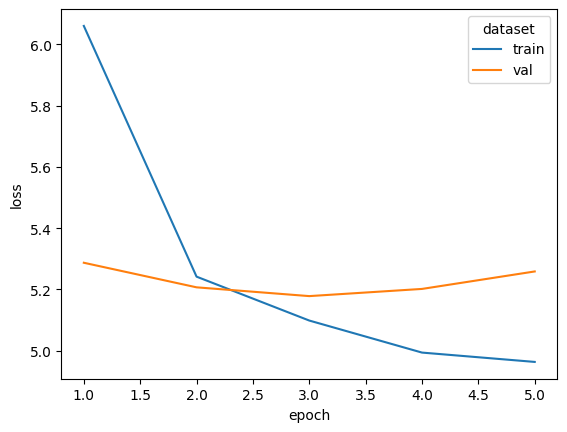

In [7]:
utils.plot_train_losses(train_losses, val_losses)

## Generate Text with Model

Start by loading a model and instantiating a tokenizer that can also map from tokens back to text. The `load_model` function will load the best performing model that has been persisted on the local filesystem.

In [8]:
best_model: tfr.NextWordPredictionTransformer = utils.load_model(MODEL_NAME)

loading .models/decoder_next_word_gen/trained@2023-09-15T19:45:35;loss=5_1783.pt


Then set a prompt.

In [9]:
prompt = "This is a classic horror and"

### Greedy Decoding Strategy

Pass a prompt to the model and use a greedy decoding strategy to generate new text.Now pass a prompt to the model and get it to generate the text that comes after.

In [10]:
text = tfr.generate(
    best_model, prompt, datasets.tokenizer, "greedy", MAX_SEQ_LEN, temperature=1.0,
)
print(text)

==> THIS IS A CLASSIC HORROR AND a great movie. I dont want to watch it. I dont want to
watch it. I dont know what I mean. I dont know what I mean. I dont know what I mean. I
dont know what I mean. I dont know what I mean. I dont know what I mean. I dont know what
I mean. I dont know what I mean. I dont know what I mean. I dont know. I dont know what I
was going...........


### Top-k Decoding Strategy

Pass a prompt to the model and use a top-k decoding strategy to generate new text (with k=5).

In [11]:
text = tfr.generate(
    best_model, prompt, datasets.tokenizer, "topk", MAX_SEQ_LEN, temperature=1.0, k=5
)
print(text)

==> THIS IS A CLASSIC HORROR AND a good movie. If youre looking for a good laugh at it.
It is the worst movie ever made. I think it was not. It was a very good thing. Its a
shame that this film was made in a movie. The acting is good. The acting is good and the
only good thing about it. The movie is that I was really disappointed with this one. This
movie is so much of the movie. The acting is good. Its not good. I dont watch it was
terrible...


### Sampling Decoding Strategy

Pass a prompt to the model and use a sampling decoding strategy to generate new text.

In [12]:
text = tfr.generate(
    best_model, prompt, datasets.tokenizer, "sample", MAX_SEQ_LEN, temperature=1.0
)
print(text)

==> THIS IS A CLASSIC HORROR AND his horror style but his story is perfect. Mr qv does
not start a very dreamy and writer. Final warning stereotyping even though the directors
poor looking for some strange programme skylark sticks a whale made by people. Jason has
something of the main reason for two long long in which works these are the same and it
should be made by derek jacobi offers more convincing and homey group of artificial
family members shouldve served for anything for these people. I was practically blown up.
Its definitely spit mirrors. 6 years. Seinfeld...


### Benchmark

Compare all output with that from an untrained model.And compare this output with that from an untrained model.

In [13]:
untrained_model = tfr.NextWordPredictionTransformer(
    datasets.tokenizer.vocab_size, SIZE_EMBED
)
text = tfr.generate(
    untrained_model, prompt, datasets.tokenizer, "greedy", MAX_SEQ_LEN, temperature=1.0
)
print(text)

==> THIS IS A CLASSIC HORROR AND tsa tsa tsa wiimote wiimote upclose upclose upclose
naturalism upfront upfront upfront 1930the punctuation indiscernible upfront upfront
upfront upfront upfront upfront upfront granting whining nazarin certo certo certo
upfront perine perine centralized neurological neurological neurological crestfallen
crestfallen allfor neurological neurological neurological cassavetess perine perine
laughter laughter laughter laughter certo certo yorkavant yorkavant lacing lacing lacing
lacing allfor boredome yorkavant boredome yorkavant jobmore savannahs neurological
neurological lunchmeat badmen yorkavant yorkavant yorkavant thousands thousands thousands
thousands thousands yorkavant thousands thousands forego forego world 1930the 1930the
1930the 1930the 1930the 1930the world world thousands kinkle centralized centralized
centralized earnings earnings earnings allyway allyway xian...
